In [436]:
import warnings
warnings.filterwarnings("ignore") 
import pandas as pd
import calendar
import numpy as np
import pickle 

In [437]:
# function to extract month and year from the dataset

def week2month(hep):
    hep['LastDayWeek'] = pd.to_datetime((hep['week']-1).astype(str) + "6", format="%Y%U%w")
    hep['MonthMax'] = pd.DatetimeIndex(hep['LastDayWeek']).month
    hep['Year'] = pd.DatetimeIndex(hep['LastDayWeek']).year
    hep['MonthName'] = [calendar.month_name[i] for i in hep.MonthMax]
    return hep

In [438]:
# function to load the dataset
def get_input_transform(file_):
    return week2month(pd.read_csv(file_))

In [439]:
# load the dataset from Kaggle
hep = get_input_transform('data/hepatitis.csv')
mea = get_input_transform('data/measles.csv')
mum = get_input_transform('data/mumps.csv')
per = get_input_transform('data/pertussis.csv')
pol = get_input_transform('data/polio.csv')
rub = get_input_transform('data/rubella.csv')
sma = get_input_transform('data/smallpox.csv')

In [440]:
train_data = hep
for i in [mea,mum,per,pol,rub,sma]:
    train_data = train_data.append(i)
train_data = train_data.loc[(train_data['Year'] >= 1960) & (train_data['Year'] <=2011)]
# examine the dataset 
train_data.head()


,week,state,state_name,disease,cases,incidence_per_capita,LastDayWeek,MonthMax,Year,MonthName
0,196601,AL,ALABAMA,HEPATITIS A,5,0.14,1966-01-01,1,1966,January
1,196601,AR,ARKANSAS,HEPATITIS A,11,0.58,1966-01-01,1,1966,January
2,196601,AZ,ARIZONA,HEPATITIS A,6,0.37,1966-01-01,1,1966,January
3,196601,CA,CALIFORNIA,HEPATITIS A,89,0.47,1966-01-01,1,1966,January
4,196601,CO,COLORADO,HEPATITIS A,1,0.05,1966-01-01,1,1966,January


In [441]:
# some data discrepancies must be resolved (issues like \\N )
train_data.cases = train_data.cases.astype('str')
train_data_bad = train_data[train_data.cases==train_data.cases.max()]
ind = list(train_data_bad.index)
train_data = train_data.drop(train_data.index[ind])


In [442]:

# will be using visulisation.csv for our visualization purposes later# will b 

train_data.to_csv('for_visulisation.csv')

In [443]:
train_data.cases = train_data.cases.astype(int)

In [444]:
# examining the characteristics of the dataset
train_data.describe()

,week,cases,incidence_per_capita,MonthMax,Year
count,361935.000000,361935.000000,361935.000000,361935.000000,361935.000000
mean,198461.036059,15.238026,0.429124,6.933999,1984.325221
std,1330.980200,84.493216,2.233045,3.279924,13.298776
min,196001.000000,0.000000,0.000000,1.000000,1960.000000
25%,197349.000000,0.000000,0.000000,4.000000,1973.000000
50%,198342.000000,1.000000,0.030000,7.000000,1983.000000
75%,199524.000000,7.000000,0.190000,10.000000,1995.000000
max,201152.000000,7101.000000,209.160000,12.000000,2011.000000


In [445]:
# converting non-numerical data to lowercase (to keep consistencies over all future datasets included)

train_data.state_name = [i.lower() for i in train_data.state_name]

# Feature additions
Adding features like
- Average temperature
- Average precipitation
- Average population
- Polution standards
#### These features have certain effect on the contagious disease spread


In [446]:
join_tavg = pd.read_excel('TemperaturesByState.xlsx', index_col= 0)
# make sure non-nmerical data in lowercase format

join_tavg['Date'] = pd.to_datetime(join_tavg['Date'],format = "%Y%U%w")
join_tavg['Year'] = pd.DatetimeIndex(join_tavg['Date']).year
join_tavg['Month'] = pd.DatetimeIndex(join_tavg['Date']).month
join_tavg = join_tavg.loc[(join_tavg['Year'] >= 1960) & (join_tavg['Year'] <=2011)]
join_tavg.State = [i.lower() for i in join_tavg.State]
join_tavg = join_tavg.drop('Country',axis=1)
join_tavg.head()

# convert the column names for tavg dataset to match column names to our primary dataset
join_tavg.columns = [ 'LastDayWeek','t_avg', 'tavg_anomaly', 'state_name','Year','MonthMax']

In [447]:
# examine the dataset

print (join_tavg.shape)
join_tavg.head()

(31824, 6)


,LastDayWeek,t_avg,tavg_anomaly,state_name,Year,MonthMax
index,,,,,,
0,1960-01-01,44.9114,0.219,alabama,1960,1
0,1960-01-02,44.6396,0.221,alabama,1960,1
0,1960-01-03,45.7358,0.099,alabama,1960,1
0,1960-01-04,64.1444,0.239,alabama,1960,1
0,1960-01-05,68.1278,0.305,alabama,1960,1


In [448]:
# join the avg temperature dataset with our priary dataset over common columns

result = pd.merge(train_data, join_tavg, on=['LastDayWeek','Year','state_name','MonthMax'])

In [450]:
#examining the primary dataset

print (result.shape)
result.to_csv('for_temp_visualization.csv')
train_data = result # make this your current working dataframe 
result.head()

(5130, 12)


,week,state,state_name,disease,cases,incidence_per_capita,LastDayWeek,MonthMax,Year,MonthName,t_avg,tavg_anomaly
0,196601,AL,alabama,HEPATITIS A,5,0.14,1966-01-01,1,1966,January,40.4798,0.235
1,196601,AL,alabama,RUBELLA,7,0.20,1966-01-01,1,1966,January,40.4798,0.235
2,196601,AR,arkansas,HEPATITIS A,11,0.58,1966-01-01,1,1966,January,35.2310,0.225
3,196601,AR,arkansas,MEASLES,2,0.11,1966-01-01,1,1966,January,35.2310,0.225
4,196601,AZ,arizona,HEPATITIS A,6,0.37,1966-01-01,1,1966,January,37.9076,0.285


In [451]:
# examining the primary dataset now
train_data.head()

,week,state,state_name,disease,cases,incidence_per_capita,LastDayWeek,MonthMax,Year,MonthName,t_avg,tavg_anomaly
0,196601,AL,alabama,HEPATITIS A,5,0.14,1966-01-01,1,1966,January,40.4798,0.235
1,196601,AL,alabama,RUBELLA,7,0.20,1966-01-01,1,1966,January,40.4798,0.235
2,196601,AR,arkansas,HEPATITIS A,11,0.58,1966-01-01,1,1966,January,35.2310,0.225
3,196601,AR,arkansas,MEASLES,2,0.11,1966-01-01,1,1966,January,35.2310,0.225
4,196601,AZ,arizona,HEPATITIS A,6,0.37,1966-01-01,1,1966,January,37.9076,0.285


In [452]:
## Normalize the statistical data

from sklearn.preprocessing import MinMaxScaler as mm

scaler = mm()

# avg temp deviations
scaler.fit(train_data['tavg_anomaly'].reshape(-1,1))
train_data['tavg_anomaly'] = scaler.transform(train_data['tavg_anomaly'].reshape(-1,1))

# avg temp
scaler.fit(train_data['t_avg'].reshape(-1,1))
train_data['t_avg'] = scaler.transform(train_data['t_avg'].reshape(-1,1))



In [453]:
# examining the main dataset 

train_data.head()

,week,state,state_name,disease,cases,incidence_per_capita,LastDayWeek,MonthMax,Year,MonthName,t_avg,tavg_anomaly
0,196601,AL,alabama,HEPATITIS A,5,0.14,1966-01-01,1,1966,January,0.536052,0.235911
1,196601,AL,alabama,RUBELLA,7,0.20,1966-01-01,1,1966,January,0.536052,0.235911
2,196601,AR,arkansas,HEPATITIS A,11,0.58,1966-01-01,1,1966,January,0.482511,0.222805
3,196601,AR,arkansas,MEASLES,2,0.11,1966-01-01,1,1966,January,0.482511,0.222805
4,196601,AZ,arizona,HEPATITIS A,6,0.37,1966-01-01,1,1966,January,0.509814,0.301442


In [454]:
# save this primary dataset for future purposes

result.to_csv('result.csv',index=False)

In [455]:

# save the dataset in current working dataframe# save t 
train_data = result

In [456]:
# load this dataset for future purposes
'''
uncomment the line below when needed,
no need to perform above steps once you reach this step

'''

#train_data = pd.read_csv('result.csv')

'\nuncomment the line below when needed,\nno need to perform above steps once you reach this step\n\n'

In [457]:
# load the working dataset for future purposes (no need to do the above steps)

train_data = pd.read_csv('result.csv')

In [458]:
# examining the dataset 
train_data.head()

,week,state,state_name,disease,cases,incidence_per_capita,LastDayWeek,MonthMax,Year,MonthName,t_avg,tavg_anomaly
0,196601,AL,alabama,HEPATITIS A,5,0.14,1966-01-01,1,1966,January,0.536052,0.235911
1,196601,AL,alabama,RUBELLA,7,0.20,1966-01-01,1,1966,January,0.536052,0.235911
2,196601,AR,arkansas,HEPATITIS A,11,0.58,1966-01-01,1,1966,January,0.482511,0.222805
3,196601,AR,arkansas,MEASLES,2,0.11,1966-01-01,1,1966,January,0.482511,0.222805
4,196601,AZ,arizona,HEPATITIS A,6,0.37,1966-01-01,1,1966,January,0.509814,0.301442


In [459]:
# check for any duplicacy in the dataset (0: no duplicates)

train_data.duplicated(subset=None, keep='first').sum()

0

In [460]:
# remove the useless attributes from the dataset 

# store unique state_name and diseases for label encoding (dont drop them!)
states = np.asarray(train_data.state_name.unique())
#dis = np.unique(train_data['disease'].values)

week       = train_data.pop('week')
monthN     = train_data.pop('MonthName')
LOW        = train_data.pop('LastDayWeek')
state     = train_data.pop('state')
train_data.head()

,state_name,disease,cases,incidence_per_capita,MonthMax,Year,t_avg,tavg_anomaly
0,alabama,HEPATITIS A,5,0.14,1,1966,0.536052,0.235911
1,alabama,RUBELLA,7,0.20,1,1966,0.536052,0.235911
2,arkansas,HEPATITIS A,11,0.58,1,1966,0.482511,0.222805
3,arkansas,MEASLES,2,0.11,1,1966,0.482511,0.222805
4,arizona,HEPATITIS A,6,0.37,1,1966,0.509814,0.301442


In [461]:
# Create test_train splits

from sklearn.model_selection import train_test_split as tts

y = train_data.pop('disease')
train, test, y_train, y_test = tts(train_data, y,test_size = 0.4)

In [462]:
print (train.shape)
print (y_train.shape)

print (test.shape)
print (y_test.shape)

(3078, 7)
(3078,)
(2052, 7)
(2052,)


In [463]:
# examine the test/train data now (uncomment the one you want to examine)

train.describe()
#test.describe()

,cases,incidence_per_capita,MonthMax,Year,t_avg,tavg_anomaly
count,3078.000000,3078.000000,3078.0,3078.000000,3078.000000,3078.000000
mean,27.077648,0.914802,1.0,1977.236517,0.671871,0.244516
std,84.035464,2.974021,0.0,11.322952,0.183459,0.114407
min,1.000000,0.000000,1.0,1960.000000,0.030241,0.006553
25%,2.000000,0.050000,1.0,1969.000000,0.532876,0.166448
50%,5.000000,0.160000,1.0,1975.000000,0.687522,0.230668
75%,18.000000,0.527500,1.0,1982.000000,0.834971,0.301442
max,1540.000000,45.250000,1.0,2011.000000,0.992086,1.000000


In [464]:
# label encoding of useful non-numerical attributes

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

le2 = LabelEncoder()
le2.fit(states)

train['state_name'] = le2.transform(train.state_name)
test['state_name'] = le2.transform(test.state_name)

In [465]:
# check dtypes of each attribute (numst be numerical)

test.dtypes

state_name                int64
cases                     int64
incidence_per_capita    float64
MonthMax                  int64
Year                      int64
t_avg                   float64
tavg_anomaly            float64
dtype: object

In [466]:
#model training (try to load few classifiers for examining performance and chose the best)

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

classifiers=[
    (LogisticRegression(penalty='l1'),"LR"),
    (KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm = 'auto'),"KNC"),
    (SVC(),'SVC'),
    (QuadraticDiscriminantAnalysis(),'QDA'),
    (RandomForestClassifier(max_depth=50, n_estimators=10, max_features=1),'RFC'),
    (AdaBoostClassifier(),'ADC'),
    (SGDClassifier(),'SGDC'),
    (DecisionTreeClassifier(max_depth=5),'DTC'),
    (LinearDiscriminantAnalysis(),'LDA'),
    (MNB(), 'MNB')
]

eval_ =[]
train_acc, test_acc, name = [], [], []
f1_, rec_, prec_ = [], [], []
for clf in classifiers:
    print ("training...%s",clf[1])
    clf[0].fit(train, y_train)
    y_preds = clf[0].predict(test)
    y_preds_train = clf[0].predict(train)
    name.append(clf[1])
    train_acc.append( accuracy_score(y_train, y_preds_train)*100 )
    test_acc.append( accuracy_score(y_test, y_preds)*100 )
    f1_.append( f1_score(y_test, y_preds, average='macro')*100 )
    rec_.append( recall_score(y_test, y_preds, average='macro')*100 )
    prec_.append( precision_score(y_test, y_preds, average='macro')*100 )
    print (clf[1])
    print ("testing_accuracy", accuracy_score(y_test, y_preds)*100)
    print ("training_accuracy", accuracy_score(y_train, y_preds_train)*100)
    print ("precision_test: ", precision_score(y_test, y_preds, average='macro')*100)
    print ("f1_score: ", f1_score(y_test, y_preds, average='macro')*100)
    print ("recall_score: ", recall_score(y_test, y_preds, average='macro')*100)
eval_.append(train_acc)
eval_.append(test_acc)
eval_.append(f1_)
eval_.append(rec_)
eval_.append(prec_)

training...%s LR
LR
testing_accuracy 40.7407407407
training_accuracy 39.0513320338
precision_test:  24.0268755336
f1_score:  16.7733117428
recall_score:  22.3808185176
training...%s KNC
KNC
testing_accuracy 39.7660818713
training_accuracy 96.4262508122
precision_test:  43.1028869395
f1_score:  42.2935821556
recall_score:  41.7221130345
training...%s SVC
SVC
testing_accuracy 42.2514619883
training_accuracy 72.1247563353
precision_test:  45.1379606101
f1_score:  39.3745570449
recall_score:  37.5345799462
training...%s QDA
QDA
testing_accuracy 30.1169590643
training_accuracy 29.6621182586
precision_test:  41.8821947819
f1_score:  26.4878724711
recall_score:  30.9940973172
training...%s RFC
RFC
testing_accuracy 42.3976608187
training_accuracy 94.6718648473
precision_test:  44.9216442165
f1_score:  41.9992530344
recall_score:  40.4217544425
training...%s ADC
ADC
testing_accuracy 41.8615984405
training_accuracy 40.9356725146
precision_test:  48.8424036753
f1_score:  29.4937704221
recall_scor

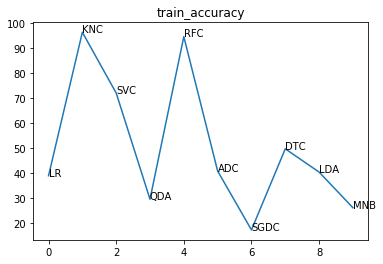

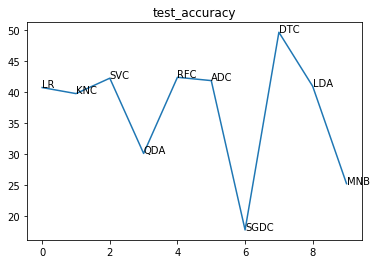

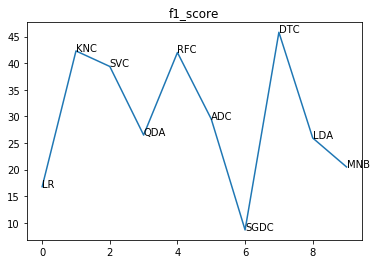

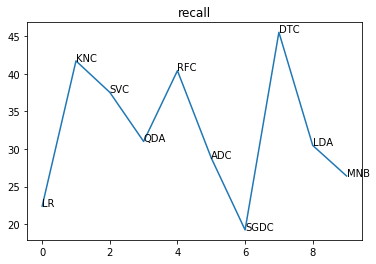

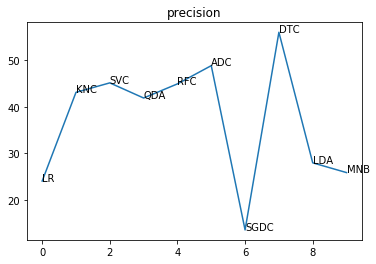

In [467]:
from matplotlib import pyplot as plt

titles = ['train_accuracy', 'test_accuracy', 'f1_score', 'recall', 'precision']

for i in range(len(eval_)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    A = eval_[i][:]
    plt.title(titles[i])
    plt.plot(A)
    for j, label in enumerate(name):
        plt.text(j,A[j], label) 
    plt.show()

In [468]:
# using plotly for the beautiful plots 

import plotly.plotly as py
import plotly
import pandas as pd

# login api for plotly (dont forget to sign up to plotly)
plotly.tools.set_credentials_file(username= 'Ubaid01', api_key = "ip2KAG3NXA4zbbzIzbzY")

In [469]:
# for UI

import pandas as pd 
import numpy as np
import plotly.offline as py

def get_viz(the_yr_data, yr):
    py.init_notebook_mode(connected=True)


    for col in the_yr_data.columns:
        the_yr_data[col] = the_yr_data[col].astype(str)

    
    scl = [
            # Let first 10% (0.1) of the values have color rgb(0, 0, 0)
            [0, 'rgb(0, 0, 0)'],
            [0.1, 'rgb(0, 0, 0)'],

            # Let values between 10-20% of the min and max of z
            # have color rgb(20, 20, 20)
            [0.1, 'rgb(20, 20, 20)'],
            [0.2, 'rgb(20, 20, 20)'],

            # Values between 20-30% of the min and max of z
            # have color rgb(40, 40, 40)
            [0.2, 'rgb(40, 40, 40)'],
            [0.3, 'rgb(40, 40, 40)'],

            [0.3, 'rgb(60, 60, 60)'],
            [0.4, 'rgb(60, 60, 60)'],

            [0.4, 'rgb(80, 80, 80)'],
            [0.5, 'rgb(80, 80, 80)'],

            [0.5, 'rgb(100, 100, 100)'],
            [0.6, 'rgb(100, 100, 100)'],

            [0.6, 'rgb(120, 120, 120)'],
            [0.7, 'rgb(120, 120, 120)'],

            [0.7, 'rgb(140, 140, 140)'],
            [0.8, 'rgb(140, 140, 140)'],

            [0.8, 'rgb(160, 160, 160)'],
            [0.9, 'rgb(160, 160, 160)'],

            [0.9, 'rgb(180, 180, 180)'],
            [1.0, 'rgb(180, 180, 180)']
        ]
    data = [ dict(
            type='choropleth',
            colorscale = scl,
            autocolorscale = True,
            locations = the_yr_data['state'],
            z = the_yr_data['cases'].astype(float),
            zmin=0,
            zmax=500,
            locationmode = 'USA-states',
            text = the_yr_data['text'],
            marker = dict(
                line = dict (
                    color = 'rgb(255,255,255)',
                    width = 2
                )
            ),
            colorbar = dict(
                title = "Disease outbreak - cases in %d" %(yr)
            )
        ) ]

    layout = dict(
        title = '%d US Diseases Cases Found by State<br>(Hover for breakdown)' %(yr),
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
            ),
    )

    fig = dict( data=data, layout=layout )

    url = py.iplot( fig, validate=False)

def get_1yr_viz(yr):
    data = pd.read_csv('for_visulisation.csv')
    the_yr_data = data.loc[data['Year'] ==yr]
    the_yr_data.head()
    from collections import defaultdict
    har = defaultdict(set)
    a = list(the_yr_data.state_name)
    b = list(the_yr_data.disease)
    for i in range(len(a)):
        har[a[i]].add(b[i])
    print(len(a),len(b))
    the_yr_data['disease_all'] = [' '.join(list(har[i])) for i in the_yr_data.state_name]
    the_yr_data['text'] = the_yr_data['state_name'] + '<br>' +\
    'Disease '+the_yr_data['disease_all']
    
    tf = the_yr_data.filter(['state_name','state','cases'], axis=1)
    tf.cases = tf.cases.astype(int)
    the_yr_data_2 = tf.groupby(['state_name','state']).sum().reset_index()
    the_yr_data_2['disease_all'] = [' '.join(list(har[i])) for i in the_yr_data_2.state_name]
    the_yr_data_2['text'] = the_yr_data_2['state_name'] + '<br>' +\
    'Disease '+the_yr_data_2['disease_all']
    
    get_viz(the_yr_data_2, yr)

In [470]:
 #get visualization for any year

get_1yr_viz(1977)

9816 9816
